In [1]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.random as jr
from jax.config import config
import seaborn as sns
from glob import glob 
import numpy as np 
import xarray as xr
from tqdm import tqdm, trange

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

%matplotlib inline

2022-06-01 11:04:26.965561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Load 50 observational reasliations

/home/amosm1/bayesian_ensembling/ensembles/data.py:242: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')


<AxesSubplot:title={'center':'Observations'}>

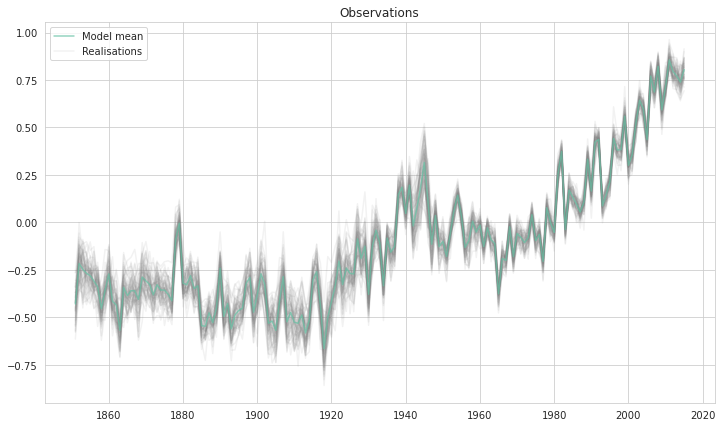

In [2]:
obs_da = xr.open_mfdataset(glob('./../experiments/data/obs/gridded/Had*.nc'), combine='nested', concat_dim='realization').tas[:50].load()
obs_da = obs_da.rename(realization='realisation')
obs_da = obs_da.sel(time=slice('1850-01-01', '2014-12-31'))
obs_time = obs_da.time
obs_da = obs_da.resample(time='Y').mean()
observations = es.ProcessModel(obs_da, model_name='Observations')
observations.plot()

Load some historical models

In [3]:
def prepro(ds):
    model_real = ds.encoding['source'].split('_')[-1][:-3]
    ds = ds.assign_coords(realisation=model_real)
    return ds
    
hist_files = glob('data/gridded/historical/*nc')
ssp_files = glob('data/gridded/ssp370/*nc')

unique_hist_models = np.unique([file.split('/')[-1].split('_hist')[0] for file in hist_files])
unique_ssp_models = np.unique([file.split('/')[-1].split('_ssp')[0] for file in ssp_files])
unique_models = np.intersect1d(unique_hist_models, unique_ssp_models)

hist_model_dict = dict()
for file in hist_files:
    model = file.split('/')[-1].split('_hist')[0]
    if model in unique_models:
        if model not in hist_model_dict.keys():
            hist_model_dict[model] = [file]
        else:
            hist_model_dict[model] = hist_model_dict[model] + [file]

ssp_model_dict = dict()
for file in ssp_files:
    model = file.split('/')[-1].split('_ssp')[0]
    if model in unique_models:
        if model not in ssp_model_dict.keys():
            ssp_model_dict[model] = [file]
        else:
            ssp_model_dict[model] = ssp_model_dict[model] + [file]

climatology_dict = dict()
hist_models = []
hist_anom_models = []
for mn, mfs in tqdm(hist_model_dict.items()):
    da = xr.open_mfdataset(mfs, preprocess=prepro, combine='nested', concat_dim='realisation').tas.load()#[:, :, :2, :3]
    if 'height' in da.coords:
        da = da.drop('height')
    if len(da.realisation) < 3:
        continue
    da['time'] = obs_time
    model_data = es.ProcessModel(da, mn)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(resample_freq='Y')
    hist_anom_models.append(anomaly_model)
    climatology_dict[mn] = anomaly_model.climatology

100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


Fit them reasonably well using mean field apprx

In [4]:
hist_anom_models = es.ModelCollection(hist_anom_models)
hist_anom_models.fit(es.MeanFieldApproximation(), n_optim_nits=250)

/home/amosm1/bayesian_ensembling/ensembles/models.py:101: UserWarning: No optimiser specified, using Adam with learning rate 0.01
  warnings.warn("No optimiser specified, using Adam with learning rate 0.01")
  0%|          | 0/250 [00:00<?, ?it/s]/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
Objective:  344316.06: 100%|██████████| 250/250 [00:06<00:00, 39.42it/s] 


In [26]:
weight_function = es.LogLikelihoodWeight()
lls_weights_normal = weight_function(hist_anom_models, observations, standardisation_scheme=None)
lls_weights_exp = weight_function(hist_anom_models, observations, standardisation_scheme='exp')
lls_weights_min_max = weight_function(hist_anom_models, observations, standardisation_scheme='min-max')
lls_weights_subtract = weight_function(hist_anom_models, observations, standardisation_scheme='subtract-constant')


100%|██████████| 50/50 [00:00<00:00, 560.78it/s]


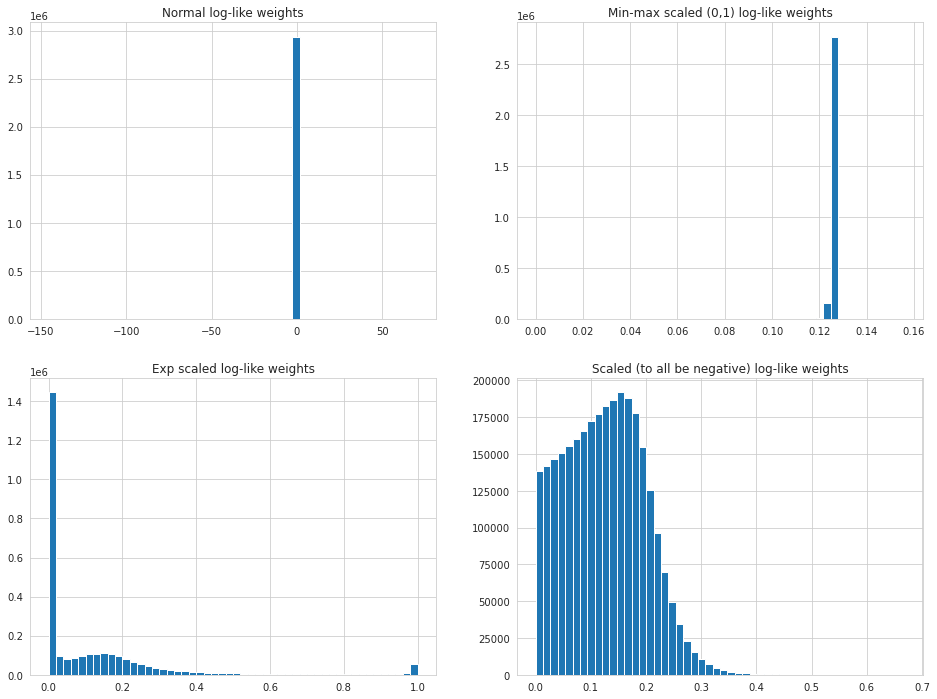

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
ax0 = axes[0][0]
ax0.hist(lls_weights_normal.values.ravel(), bins=50)
ax0.set_title('Normal log-like weights')

ax1 = axes[0][1]
ax1.hist(lls_weights_min_max.values.ravel(), bins=50)
ax1.set_title('Min-max scaled (0,1) log-like weights')

ax2 = axes[1][0]
ax2.hist(lls_weights_exp.values.ravel(), bins=50)
ax2.set_title('Exp scaled log-like weights')

ax3 = axes[1][1]
ax3.hist(lls_weights_subtract.values.ravel(), bins=50)
ax3.set_title('Scaled (to all be negative) log-like weights')

fig.show()

Things to note from the above histograms:
- Without any standardisation (top left) we get negative weights and they aren't constrained to 0-1. These are nonsense,
- Only the negative scaling (subtracting a constant to ensure negativity of log-likelihood - bottom right) looks sensible. There are 8 models so mean weighting should be about 0.125. Drawing on my previous model weighting experience this looks reasonable. This should be similar to the binned output of a symmetric dirichlet distribution shown below. It does look similar and therefore makes a reasonable amount of sense.

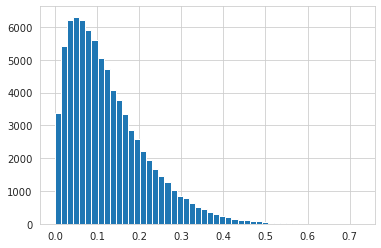

In [43]:
dirichlet_weight_sample = np.random.dirichlet([1.5] * 8, size = 10000)
plt.hist(dirichlet_weight_sample.ravel(), bins=50)
plt.show()

Check that the subtracted value doesn't affect the weights. I.e. if we make the log-likelihoods negative, does it matter by what value we subtract by. Intuitively I think this will be a problem.

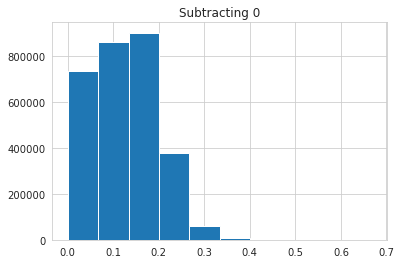

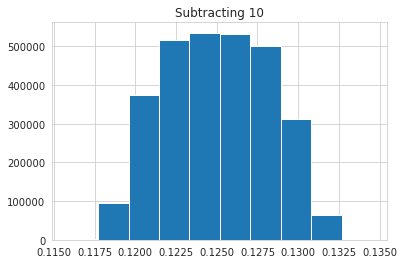

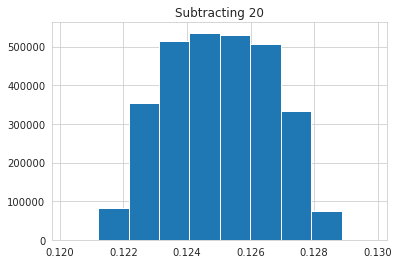

In [54]:
import jax.numpy as jnp
import copy
import distrax as dx

for i in range(3):
    model_lls = []
    for model in hist_anom_models:
        distribution = model.distribution._dist
        # Expand dims is needed to ensure that the log_prob returns one point per time point
        log_likelihood = lambda x: distribution.log_prob(x)

        lls = []
        for obs_real in observations:
            # assert distribution.event_shape == obs_real.values.ravel().shape, 'Observations are not the same size as the model distribution'
            # This is need because dx.Normal and dx.MultiVariate treat inputs differently
            if model.distribution.dist_type == dx.Normal:
                ll_val = log_likelihood(obs_real.values.ravel())
            else:
                ll_val = log_likelihood(jnp.expand_dims(obs_real.values.ravel(), -1))
            lls.append(ll_val)

        lls_array = jnp.asarray(lls)
        lls_mean = jnp.mean(lls_array, axis=0)
        lls_mean = lls_mean - np.ceil(lls_mean) - 10 * i

        lls_mean_xarray = copy.deepcopy(model.model_data.isel(realisation=0)).drop_vars('realisation')
        lls_mean_xarray.data = lls_mean.reshape(lls_mean_xarray.shape)
        lls_mean_xarray = lls_mean_xarray.assign_coords(model=model.model_name)

        model_lls.append(lls_mean_xarray)

    model_lls = xr.concat(model_lls, dim='model')
    model_lls = model_lls.rename('Log-likelihoods')
    model_lls_sum = model_lls.sum('model')
    weights = model_lls / model_lls_sum

    weights = weights.rename('Log-likelihood weights')

    plt.figure()
    plt.hist(weights.values.ravel())
    plt.title(f'Subtracting {10 * i}')
    plt.show()

It is a problem - this subtraction method won't work...

We need a scaling method that that moves from values in the range [$-\infty$, $+\infty$] to values in the range [$0$, $+\infty$]. This is because:
- The worst model will have a loglikelihood = $-\infty$
- The best model will have a loglikelihood = $+\infty$
- An unscaled weight for the best model (pre dividing by the sum of weights across models) should = $+\infty$
- An unscaled weight for the worst model (pre dividing by the sum of weights across models) should = $0$


What about an exponential scaling?

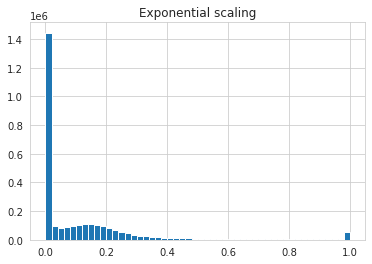

In [83]:
import jax.numpy as jnp
import copy
import distrax as dx

model_lls = []
for model in hist_anom_models:
    distribution = model.distribution._dist
    # Expand dims is needed to ensure that the log_prob returns one point per time point
    log_likelihood = lambda x: distribution.log_prob(x)

    lls = []
    for obs_real in observations:
        # assert distribution.event_shape == obs_real.values.ravel().shape, 'Observations are not the same size as the model distribution'
        # This is need because dx.Normal and dx.MultiVariate treat inputs differently
        if model.distribution.dist_type == dx.Normal:
            ll_val = log_likelihood(obs_real.values.ravel())
        else:
            ll_val = log_likelihood(jnp.expand_dims(obs_real.values.ravel(), -1))
        lls.append(ll_val)

    lls_array = jnp.asarray(lls)
    lls_mean = jnp.mean(lls_array, axis=0)
    lls_mean = np.exp(lls_mean)

    lls_mean_xarray = copy.deepcopy(model.model_data.isel(realisation=0)).drop_vars('realisation')
    lls_mean_xarray.data = lls_mean.reshape(lls_mean_xarray.shape)
    lls_mean_xarray = lls_mean_xarray.assign_coords(model=model.model_name)

    model_lls.append(lls_mean_xarray)

model_lls = xr.concat(model_lls, dim='model')
model_lls = model_lls.rename('Log-likelihoods')
model_lls_sum = model_lls.sum('model')
weights = model_lls / model_lls_sum

weights = weights.rename('Log-likelihood weights')

plt.figure()
plt.hist(weights.values.ravel(), bins=50)
plt.title(f'Exponential scaling')
plt.show()

There are a lot of models which are totally binned. Perhaps this isn't such a problem as some are really off the mark in certain places. Also, I think some of this behaviour will even out when we average the weights seasonally or in time

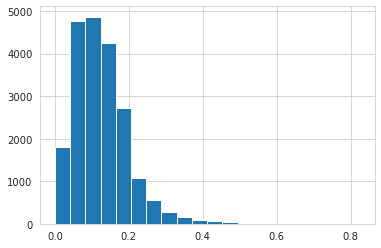

In [87]:
plt.hist(weights.mean('time').values.ravel(),bins=20)
plt.show()

When averaged like above, this is better as this is much more similar to a dirichlet style distribution

Spatially this is nice as well as we see sensible patterns in the plots. Here you can see, this model CanESM5-OE, which is the normal CanESM5 but with a better ocean geochemistry scheme, performs better over the coastal and oceanic regions around antarctica. Perhaps because it's simulating some part of the ocean-atmospheric system better.

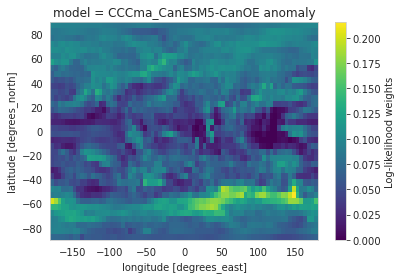

In [90]:
weights[4].mean('time').plot()

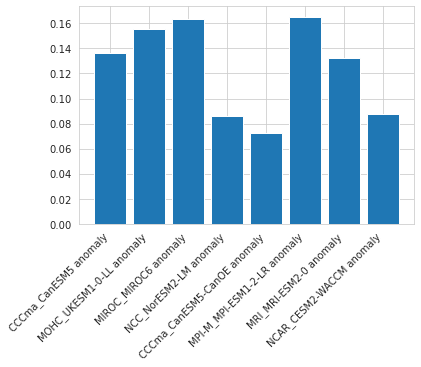

In [103]:
ave_weight = weights.mean(['time', 'latitude', 'longitude'])
plt.bar(ave_weight.model, ave_weight)
plt.xticks(rotation=45, ha='right')
plt.show()